In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv

## Plot Definitions

In [6]:
#def load_fields(source, fields, limit=None, load_unsuccessful=False):
#    with open(source, 'r') as f:
#        reader = csv.DictReader(f)
#        assert all(field in reader.fieldnames for field in fields), "Fields not found in CSV"
#
#        data = {field: [] for field in fields}
#        for row in reader:
#            if not load_unsuccessful and any(row[field] == "" for field in fields):
#                continue
#
#            for field in fields:
#                if row[field] == "":
#                    if load_unsuccessful:
#                        data[field].append("")
#                    continue
#                if limit != None and len(data[field]) > limit:
#                    break
#                data[field].append(row[field])
#    return data

In [2]:

# load_successful can be 'any', 'all' or None
# 'any': sample is loaded if any field contains data. May result in lists of unequal length
# 'all': sample is loaded only if all fields contain data. Lists will be of equal length
# None: sample is loaded regardless of data in fields
def load_fields(source, fields, limit=None, load_successful=None):
    with open(source, 'r') as f:
        reader = csv.DictReader(f)
        assert all(field in reader.fieldnames for field in fields), "Fields not found in CSV"

        data = {field: [] for field in fields}
        for row in reader:
            if load_successful == 'all' and any(row[field] == "" for field in fields):
                continue

            for field in fields:
                if load_successful == 'any' and row[field] == "":
                    continue
                if limit != None and len(data[field]) > limit:
                    break
                data[field].append(row[field])
    return data

## Basic Analysis

### QMIN

Text(0.5, 1.0, 'Maximum QMIN Iterations (416916 samples)')

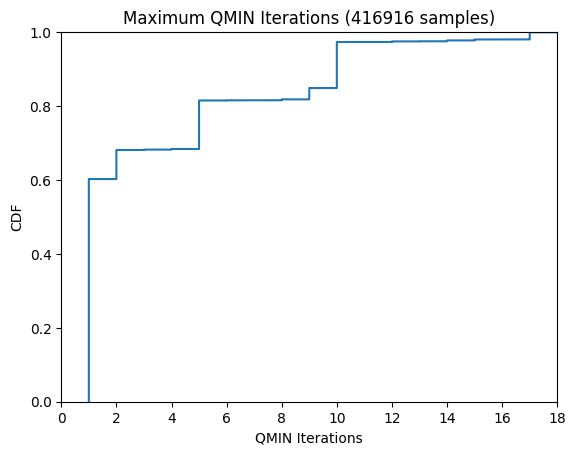

In [8]:

#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'

data = load_fields(source, ['qmin_iter'], load_successful='all')

qmin_iter = np.array(data['qmin_iter'], dtype=int)

fig, ax = plt.subplots()
ax.ecdf(qmin_iter)
ax.set_xlabel('QMIN Iterations')
ax.set_xlim(0, 18)
ax.set_xticks(np.arange(0, 20, 2))
ax.set_ylabel('CDF')
ax.set_title(f"Maximum QMIN Iterations ({len(qmin_iter)} samples)")

### TTL

Text(0.5, 1.0, 'TTL observed by Client (449275 samples)')

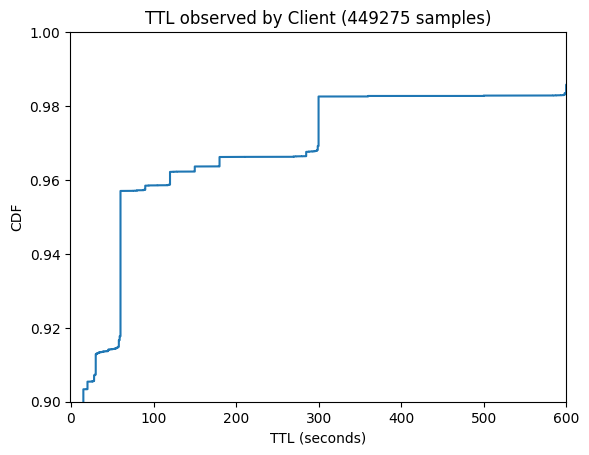

In [160]:
#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'

data = load_fields(source, ['ttl0_client_max'])

qmin_iter = np.array(data['ttl0_client_max'], dtype=int)
# Filter anything above 200
#qmin_iter = qmin_iter[qmin_iter < 60]
mask = max_ttl <= 60
fig, ax = plt.subplots()
ax.ecdf(qmin_iter)
#ax.set_xlim(-1, 61)
ax.set_ylim(0.9, 1)
ax.set_xlim(-1, 600)
ax.set_xlabel("TTL (seconds)")
ax.set_ylabel("CDF")
ax.set_title(f"TTL observed by Client ({len(qmin_iter)} samples)")

/tmp/ipykernel_133298/384819596.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Constant TTL", "Zero TTL at Client", "Server Honors Zero TTL"])


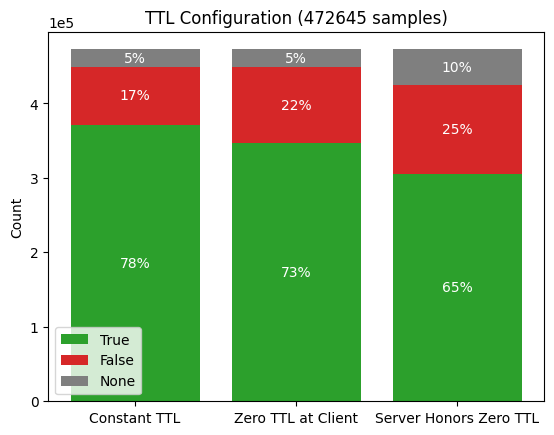

In [118]:

#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'

data = load_fields(source, ['ttl0_client_max', 'ttl_const', 'ttl0_at_client', 'ttl0_server_honors'], limit=None, load_unsuccessful=True)


#ttl_const = np.array(data['ttl_const'], dtype=bool)
# More compact code:
counts = {field: {'True': 0, 'False': 0, 'None': 0} for field in ['ttl_const', 'ttl0_at_client', 'ttl0_server_honors']}
for i in range(len(data['ttl_const'])):
    for field in counts:
        if data[field][i] == "":
            counts[field]['None'] += 1
        elif data[field][i] == 'True':
            counts[field]['True'] += 1
        elif data[field][i] == 'False':
            counts[field]['False'] += 1

col = {'True': 'C2', 'False': 'C3', 'None': 'C7'}
# Plot stacked bar for each field with one color for true and one for false
fig, ax = plt.subplots()
# Only one label
ax.bar(0, 0, color=col['True'], label='True')
ax.bar(0, 0, color=col['False'], label='False')
ax.bar(0, 0, color=col['None'], label='None')
for field, d in counts.items():
    ax.bar(field, d['True'], color=col['True'])
    ax.bar(field, d['False'], bottom=d['True'], color=col['False'])
    ax.bar(field, d['None'], bottom=d['True'] + d['False'], color=col['None'])
ax.set_ylabel('Count')
# Print percent inside each bar part
for field, d in counts.items():
    for key, value in d.items():
        base = 0
        if key == 'False':
            base = d['True']
        elif key == 'None':
            base = d['False'] + d['True']
        ax.text(field, base + value / 2, f"{value / len(data[field]) * 100:.0f}%", ha='center', va='center', color='white')


ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xticklabels(["Constant TTL", "Zero TTL at Client", "Server Honors Zero TTL"])
ax.set_title(f'TTL Configuration ({total} samples)')
ax.legend()
# Fix size
#fig.set_size_inches(6, 4)

### Number of Fetches

In [16]:

#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'

data = load_fields(source, ['fsucc_ns_tried', 'fsucc_mean_tries', 'ffail_ns_tried', 'ffail_mean_tries'], limit=None, load_successful='all')

succ_ns_tried = np.array(data['fsucc_ns_tried'], dtype=int)
succ_mean_tries = np.array(data['fsucc_mean_tries'], dtype=float)
fail_ns_tried = np.array(data['ffail_ns_tried'], dtype=int)
fail_mean_tries = np.array(data['ffail_mean_tries'], dtype=float)
assert len(succ_ns_tried) == len(succ_mean_tries) == len(fail_ns_tried) == len(fail_mean_tries)

#### NS Fetches

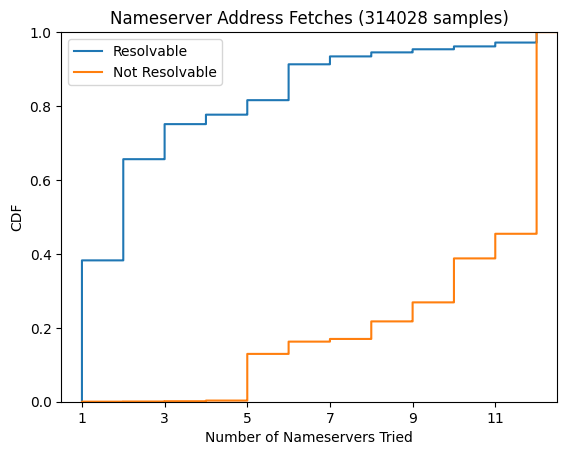

In [17]:

fig, ax = plt.subplots()
ax.ecdf(succ_ns_tried, label='Resolvable')
ax.ecdf(fail_ns_tried, label='Not Resolvable')
ax.set_xlim(0.5, 12.5)
ax.set_xticks(np.arange(1, 13, 2))
ax.set_xlabel("Number of Nameservers Tried")
ax.set_ylabel("CDF")
ax.set_title(f"Nameserver Address Fetches ({len(succ_ns_tried)} samples)")
ax.legend()


#### Mean Retries CDF

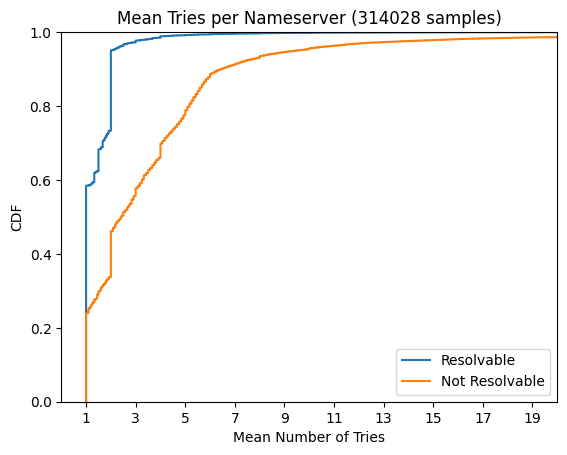

In [18]:

fig, ax = plt.subplots()
ax.ecdf(succ_mean_tries, label='Resolvable')
ax.ecdf(fail_mean_tries, label='Not Resolvable')
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(1, 21, 2))
ax.set_xlabel("Mean Number of Tries")
ax.set_ylabel("CDF")
ax.set_title(f"Mean Tries per Nameserver ({len(succ_mean_tries)} samples)")
ax.legend()

#### NS Fetch Scatter

Text(0, 0.5, 'Mean Number of Tries')

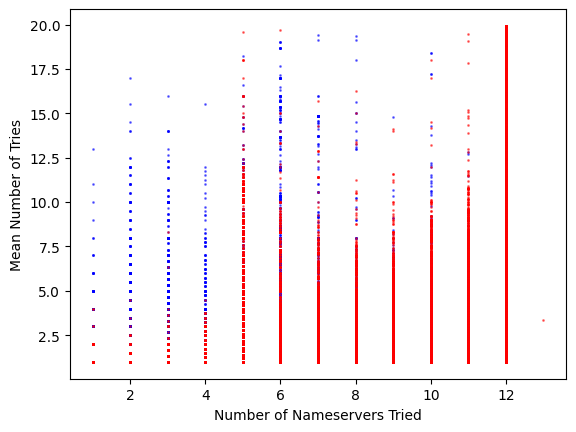

In [22]:
fig, ax = plt.subplots()
mask = (succ_mean_tries < 20) & (fail_mean_tries < 20)
ax.scatter(succ_ns_tried[mask], succ_mean_tries[mask], s=1, alpha=0.5, c='b', label='Resolvable')
ax.scatter(fail_ns_tried[mask], fail_mean_tries[mask], s=1, alpha=0.5, c='r', label='Not Resolvable')
ax.set_xlabel("Number of Nameservers Tried")
ax.set_ylabel("Mean Number of Tries")

### RD Zero

Text(0.5, 1.0, 'RD Zero Behavior (347659 samples)')

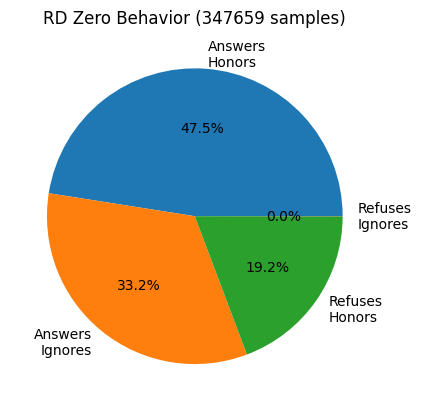

In [25]:

#source = 'public1000-3/aggregated/all.csv'
source = 'all.csv'

fields = ["rd0_ans_hon", "rd0_ans_ign", "rd0_ref_hon", "rd0_ref_ign"]
data = load_fields(source, fields, limit=None, load_unsuccessful=True)

fig, ax = plt.subplots()

# Pie Chart
counts = [0, 0, 0, 0]
for i in range(len(data['rd0_ans_hon'])):
    if data['rd0_ans_hon'][i] == 'True':
        counts[0] += 1
    elif data['rd0_ans_ign'][i] == 'True':
        counts[1] += 1
    elif data['rd0_ref_hon'][i] == 'True':
        counts[2] += 1
    elif data['rd0_ref_ign'][i] == 'True':
        counts[3] += 1

ax.pie(counts, labels=["Answers\nHonors", "Answers\nIgnores", "Refuses\nHonors", "Refuses\nIgnores"], autopct='%1.1f%%')

ax.set_title(f"RD Zero Behavior ({sum(counts)} samples)")
#ax.legend()

### CNAME Chains

In [9]:

#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'

fields = ["cc_mean_tries", "cc_length"]
data = load_fields(source, fields, limit=None, load_successful='all')

chain_len = np.array(data['cc_length'], dtype=int)
mean_tries = np.array(data['cc_mean_tries'], dtype=float)

#### Chain Length CDF

Text(0.5, 1.0, 'CNAME Chain Traversal (441679 samples)')

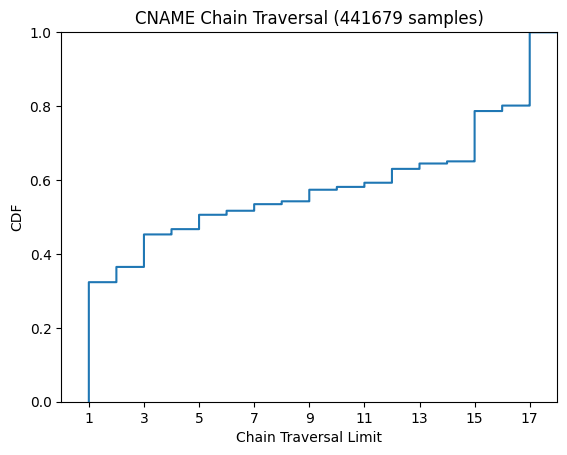

In [48]:

fig, ax = plt.subplots()
ax.ecdf(chain_len)
ax.set_xlim(0, 18)
ax.set_xticks(np.arange(1, 18, 2))
ax.set_xlabel("Chain Traversal Limit")
ax.set_ylabel("CDF")
ax.set_title(f"CNAME Chain Traversal ({len(chain_len)} samples)")


#### Mean Tries CDF

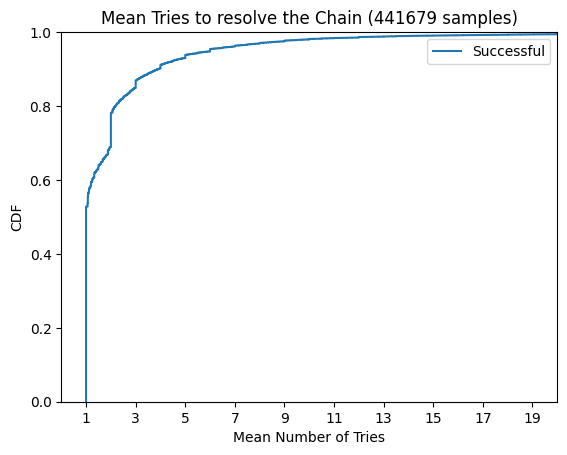

In [47]:

fig, ax = plt.subplots()
ax.ecdf(mean_tries, label='Successful')
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(1, 21, 2))
ax.set_xlabel("Mean Number of Tries")
ax.set_ylabel("CDF")
ax.set_title(f"Mean Tries to resolve the Chain ({len(mean_tries)} samples)")
ax.legend()

#### Both together

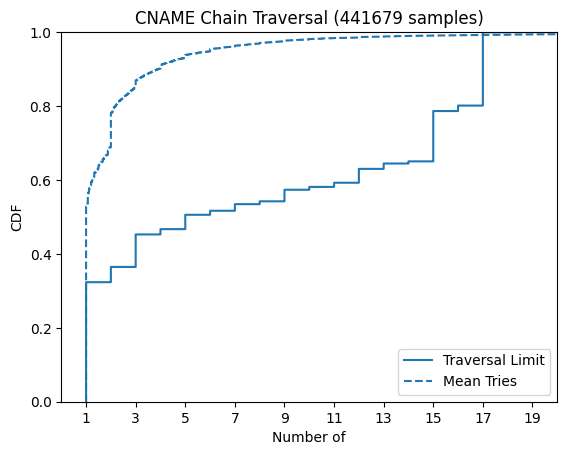

In [53]:

fig, ax = plt.subplots()
ax.ecdf(chain_len, color='C0', linestyle='solid' , label='Traversal Limit')
ax.ecdf(mean_tries, color='C0', linestyle='dashed', label='Mean Tries')
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(1, 21, 2))
ax.set_xlabel("Number of")
ax.set_ylabel("CDF")
ax.set_title(f"CNAME Chain Traversal ({len(chain_len)} samples)")
ax.legend()


#### Chain Length Scatte

Text(0, 0.5, 'Mean Tries')

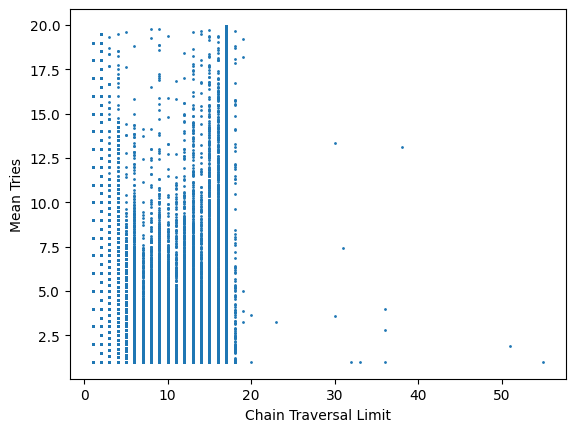

In [14]:
fig, ax = plt.subplots()
#mask = (mean_tries < 20) & (chain_len < 20)
mask = mean_tries < 20
ax.scatter(chain_len[mask], mean_tries[mask], s=1)
ax.set_xlabel("Chain Traversal Limit")
ax.set_ylabel("Mean Tries")
#ax.scatter(chain_len, mean_tries, s=1)

### Enum

#### Enum Scatter

In [112]:

#source = 'public1000-3/aggregated/all.csv'
#source = 'public1000-3/aggregated/enum_thorough.csv'
#source = 'agg600k1vp/all.csv'
source = 'agg600k1vp/enum_thorough.csv'
fields = ["num_egress", "num_entries", "discovery_quot", "variance", "num_timeout", "num_noerror", "num_query_sent", "entry_delta"]
data = load_fields(source, fields, limit=None, load_successful='all')

egress = np.array(data['num_egress'], dtype=int)
entries = np.array(data['num_entries'], dtype=int)
quot = np.array(data['discovery_quot'], dtype=float)
var = np.array(data['variance'], dtype=float)
timeout = np.array(data['num_timeout'], dtype=int)
noerror = np.array(data['num_noerror'], dtype=int)
sent = np.array(data['num_query_sent'], dtype=int)
delta = np.array(data['entry_delta'], dtype=float)
print(len(delta))
# Exclude samples where both, timeout and noerror is 0
#mask = (timeout > 0) | (noerror > 0)
#mask = mask & (entries < 2000)
#mask = entries < 2000
#egress = egress[mask]
#entries = entries[mask]
#quot = quot[mask]
#var = var[mask]
#timeout = timeout[mask]
#noerror = noerror[mask]
#sent = sent[mask]
#delta = delta[mask]

#frac_noerror = noerror / entries
frac_noerror = noerror / sent

width = 10

428889


Text(0.5, 1.0, 'Unique Egress IPs vs Log Entries (99.72% out of 428889 samples)')

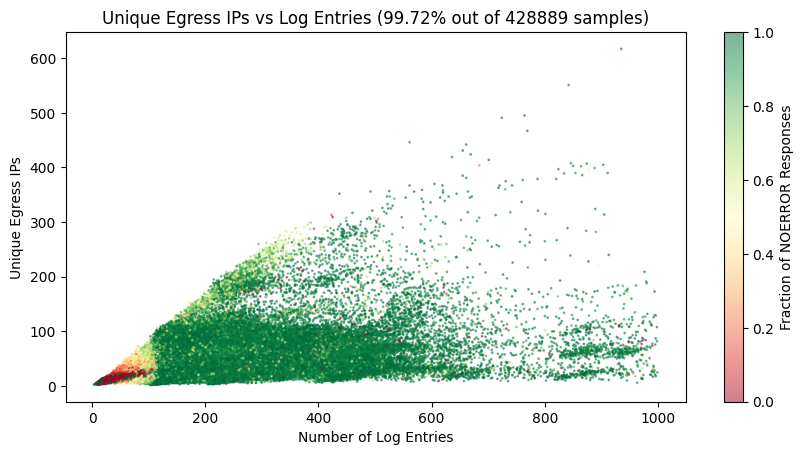

In [113]:

# Scatter plot for Egress IPs vs Log Entries
fig, ax = plt.subplots()
fig.set_figwidth(width)
mask = (entries < 1000)
ax.scatter(entries[mask], egress[mask], c=frac_noerror[mask], cmap='RdYlGn', s=1, alpha=0.5)
ax.set_xlabel('Number of Log Entries')
ax.set_ylabel('Unique Egress IPs')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Fraction of NOERROR Responses')

frac = "{:.2f}".format(100 * np.sum(mask) / len(entries))
ax.set_title(f'Unique Egress IPs vs Log Entries ({frac}% out of {len(entries)} samples)')

#### Egress IP vs. Discovery Quotient

- top right: we must be hitting ratelimits or get statuses other than NOERROR

Text(0.5, 1.0, 'Unique Egress IPs vs Discovery Quotient (99.72% of 428889 samples)')

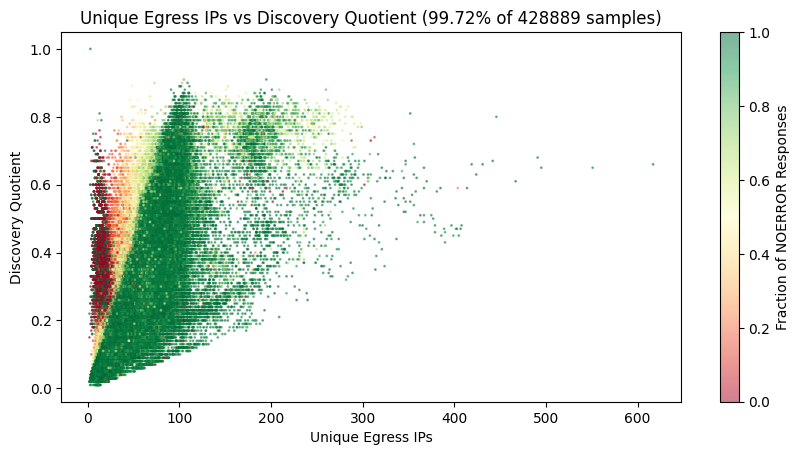

In [114]:

# Scatter plot for Egress IPs vs Discovery Quotient
fig, ax = plt.subplots()
fig.set_figwidth(width)
mask = (entries < 1000)
ax.scatter(egress[mask], quot[mask], c=frac_noerror[mask], cmap='RdYlGn', s=1, alpha=0.5)
#ax.scatter(egress, quot, c=frac_noerror, cmap='RdYlGn', s=1, alpha=0.5)
ax.set_xlabel('Unique Egress IPs')
ax.set_ylabel('Discovery Quotient')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Fraction of NOERROR Responses')
#ax.set_xlim(-1, 180)
frac = "{:.2f}".format(100 * np.sum(mask) / len(entries))
ax.set_title(f'Unique Egress IPs vs Discovery Quotient ({frac}% of {len(entries)} samples)')

#### Egress vs. Variance

Text(0.5, 1.0, 'Unique Egress IPs vs Variance (99.72% of 428889 samples)')

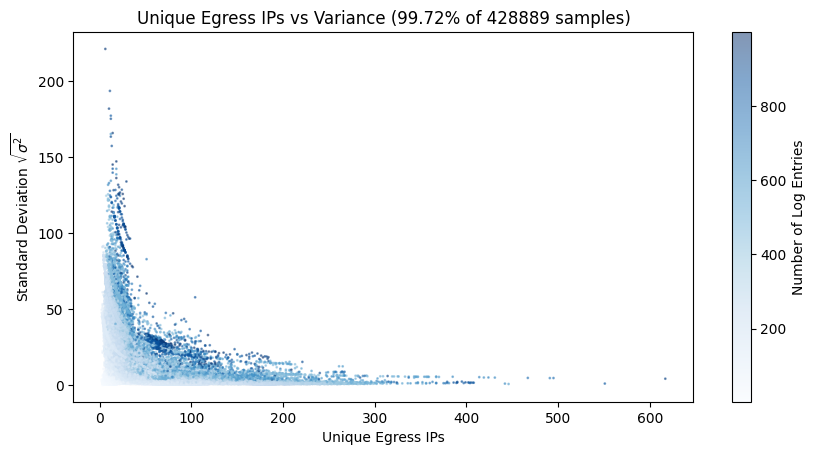

In [115]:

# Scatter plot for Number of Egress vs Variance
fig, ax = plt.subplots()
fig.set_figwidth(width)
mask = (entries < 1000)
ax.scatter(egress[mask], np.sqrt(var[mask]), c=entries[mask], cmap='Blues', s=1, alpha=0.5)
#ax.scatter(egress, np.sqrt(var), c=entries, cmap='Blues', s=1, alpha=0.5)
ax.set_xlabel('Unique Egress IPs')
ax.set_ylabel(r'Standard Deviation $\sqrt{\sigma^2}$')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Number of Log Entries')

frac = "{:.2f}".format(100 * np.sum(mask) / len(entries))
ax.set_title(f"Unique Egress IPs vs Variance ({frac}% of {len(egress)} samples)")

#### Log Entry Time Delta

Text(0.5, 1.0, 'Log Entry Time Delta CDF (428889 samples)')

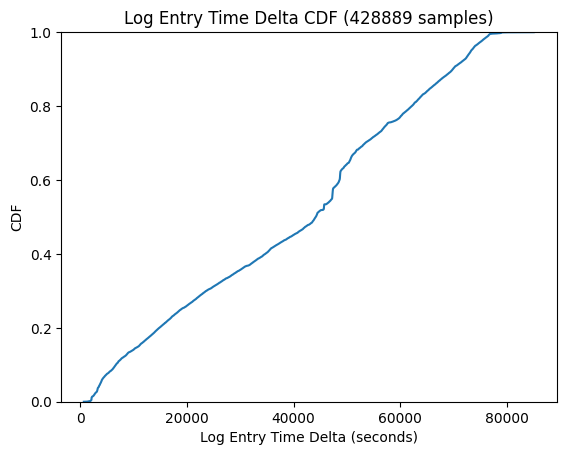

In [111]:

# CDF for Time Delta
fig, ax = plt.subplots()

#delta_ts = delta.astype('timedelta64[s]')
#ax.ecdf(delta_ts, label='Egress IPs')
ax.ecdf(delta, label='Egress IPs')
ax.set_xlabel('Log Entry Time Delta (seconds)')
ax.set_ylabel('CDF')
ax.set_title(f"Log Entry Time Delta CDF ({len(delta)} samples)")

#### Responses NOERROR vs. TIMEOUT

Text(0, 0.5, 'Number of NoError Responses')

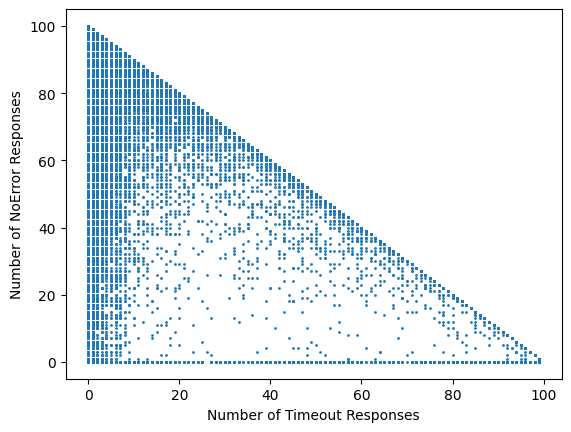

In [110]:


# Scatter of Timeout vs NoError
fig, ax = plt.subplots()
ax.scatter(timeout, noerror, s=1)
ax.set_xlabel('Number of Timeout Responses')
ax.set_ylabel('Number of NoError Responses')


#### Resolver Type Pie Chart

In [7]:
#source = 'public1000-3/aggregated/all.csv'
source = 'agg600k1vp/all.csv'
fields = ["ip_match", "single_egress"]
data = load_fields(source, fields, limit=None, load_successful='all')

Text(0.5, 1.0, 'IP Match, Single Egress, Multiple Egress (428889 samples)')

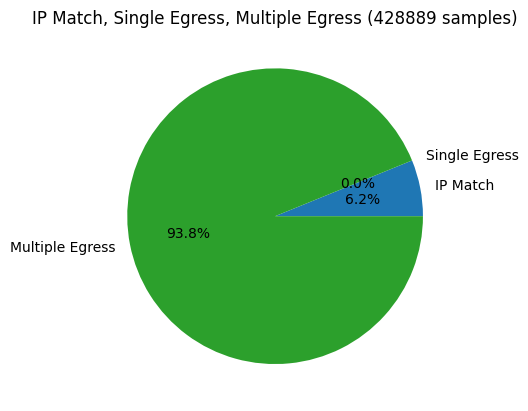

In [8]:

# Pie chart for IP Match, Single Egress, Multiple Egress
fig, ax = plt.subplots()
counts = [0, 0, 0]
for i in range(len(data['ip_match'])):
    if data['ip_match'][i] == 'True':
        counts[0] += 1
    elif data['single_egress'][i] == 'True':
        counts[1] += 1
    else:
        counts[2] += 1
ax.pie(counts, labels=["IP Match", "Single Egress", "Multiple Egress"], autopct='%1.1f%%')
ax.set_title(f"IP Match, Single Egress, Multiple Egress ({sum(counts)} samples)")


### Diverse Booleans

In [78]:

# Horizontal stacked bar plot for boolean fields
source = 'agg600k1vp/all.csv'
#source = 'public1000-3/aggregated/all.csv'
# Include cc_wildcard
fields = ["ip_match", "cc_wildcard", "cc_fine_gran", "fsucc_fine_gran", "ttl0_at_client", "ttl0_server_honors", "shared_frontend"]
labels = [
    "Ingress IP in \nEgress IP Set", 
    #"Single Egress IP\nnot equal Ingress", 
    "CNAME Chain\nUses Wildcards",
    "CNAME Chain\nFine Granularity", 
    "NS Fetch\nFine Granularity",
    "Forwards TTL0\nto Client",
    "Server Honors\nZero TTL", 
    "Shared Frontend\nBehavior"]
#"rd0_ans_hon", "rd0_ans_ign", "rd0_ref_hon", "rd0_ref_ign"]
data = load_fields(source, fields, limit=None, load_successful=None)

/tmp/ipykernel_10104/2333519968.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


Text(0.5, 1.0, 'Boolean Properties (476707 samples)')

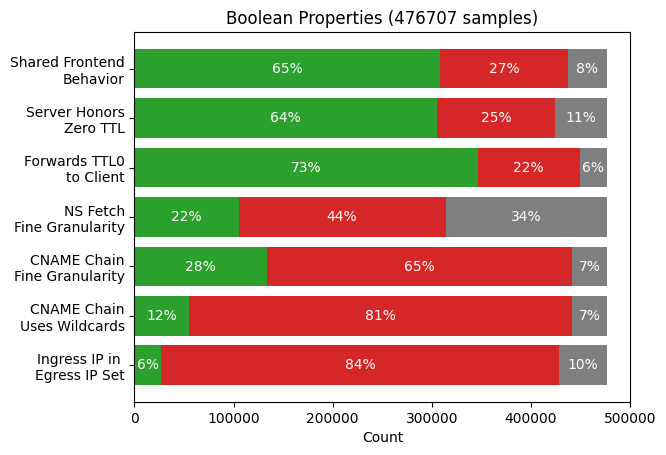

In [80]:


fig, ax = plt.subplots()
counts = {field: {'True': 0, 'False': 0, 'None': 0} for field in fields}
for i in range(len(data['ip_match'])):
    for field in counts:
        if data[field][i] == "":
            counts[field]['None'] += 1
        elif data[field][i] == 'True':
            counts[field]['True'] += 1
        elif data[field][i] == 'False':
            counts[field]['False'] += 1

col = {'True': 'C2', 'False': 'C3', 'None': 'C7'}
# Plot stacked bar for each field with one color for true and one for false
# Make the bar horizontal
ax.barh(0, 0, color=col['True'], label='True')
ax.barh(0, 0, color=col['False'], label='False')
ax.barh(0, 0, color=col['None'], label='None')
for field, d in counts.items():
    ax.barh(field, d['True'], color=col['True'])
    ax.barh(field, d['False'], left=d['True'], color=col['False'])
    ax.barh(field, d['None'], left=d['True'] + d['False'], color=col['None'])
ax.set_xlabel('Count')
# Print percent inside each bar part
for field, d in counts.items():
    for key, value in d.items():
        base = 0
        if key == 'False':
            base = d['True']
        elif key == 'None':
            base = d['False'] + d['True']
        ax.text(base + value / 2, field, f"{value / len(data[field]) * 100:.0f}%", ha='center', va='center', color='white')

ax.set_yticklabels(labels)
ax.set_title(f'Boolean Properties ({len(data["ip_match"])} samples)')

## Amplification Analysis

In [15]:

def error_plot(ax, maf, prediction, xlim=200, drop=0.05):
    error = np.abs(maf - prediction)
    # Remove 1% of the largest errors
    error = np.sort(error)
    if drop != None and drop > 0:
        error = error[:-int(len(error) * drop)]
    #plt.hist(error, bins=100)
    ax.ecdf(error)
    ax.set_xlabel('Error')
    ax.set_ylabel('CDF')
    # Limit x axis
    ax.set_xlim(-1, xlim)
    ax.set_title('Error CDF')

In [16]:

def maf_plot(ax, maf, xlim=200, drop=0.05):
    error = np.array(maf)
    # Remove 1% of the largest errors
    error = np.sort(error)
    if drop != None and drop > 0:
        error = error[:-int(len(error) * drop)]
    #plt.hist(error, bins=100)
    ax.ecdf(error)
    ax.set_xlabel('MAF')
    ax.set_ylabel('CDF')
    # Limit x axis
    ax.set_xlim(-1, xlim)
    ax.set_title(f"MAF CDF ({len(maf)} samples)")

In [17]:

def scatter_plot(ax, maf, prediction, drop=0.05):
    # Sort maf and prediction by maf
    sorted_tuples = sorted(zip(maf, prediction))
    # Drop 5% of the largest errors
    if drop != None and drop > 0:
        sorted_tuples = sorted_tuples[:-int(len(sorted_tuples) * drop)]
    maf, prediction = zip(*sorted_tuples)
    
    x = np.linspace(0, len(maf), len(maf))
    #maf = [x for _, x in sorted(zip(maf, maf))]
    #prediction = [x for _, x in sorted(zip(maf, prediction))]
    ax.scatter(x, maf, s=1, c='r', label='MAF')
    ax.scatter(x, prediction, s=1, c='b', label='Prediction')
    ax.set_xlabel('Sample')
    ax.set_ylabel('MAF')
    ax.set_title('MAF vs Prediction')
    ax.legend()

In [20]:

def load_data(source):
    with open(source, 'r') as f:
        reader = csv.DictReader(f)
        maf_field = [f for f in reader.fieldnames if f.startswith('maf_amp_')]
        assert len(maf_field) == 1, "MAF field not found or multiple found"
        maf_field = maf_field[0]
        
        pred_field = [f for f in reader.fieldnames if f.startswith('pred_')]
        assert len(pred_field) == 1, "Prediction field not found or multiple found"
        pred_field = pred_field[0]

        maf = []
        prediction = []
        for row in reader:
            if row[maf_field] == "" or row[pred_field] == "":
                continue
            maf.append(float(row[maf_field]))
            prediction.append(float(row[pred_field]))
    return np.array(maf), np.array(prediction)

#### MAF Prediction Error CDF 

In [81]:

#source_dir = 'public1000-3/aggregated'
source_dir = 'agg600k1vp'

data_source = {
  "WC6-FO6": "wc6-fo6_prediction.csv",
  "FO6-WC6": "fo6-wc6_prediction.csv",
  "WC11-QM9": "wc11-qm9_prediction.csv",
  "FO8-FO8": "fo8-fo8_prediction.csv",
  "FO16-QM12": "fo16-qm12_prediction.csv",
}
#maf, prediction = load_data(source, 'FO8-FO8', limit=4000)
data = {}
for composition, source in data_source.items():
    maf, prediction = load_data(f"{source_dir}/{source}")
    data[composition] = (maf, prediction)

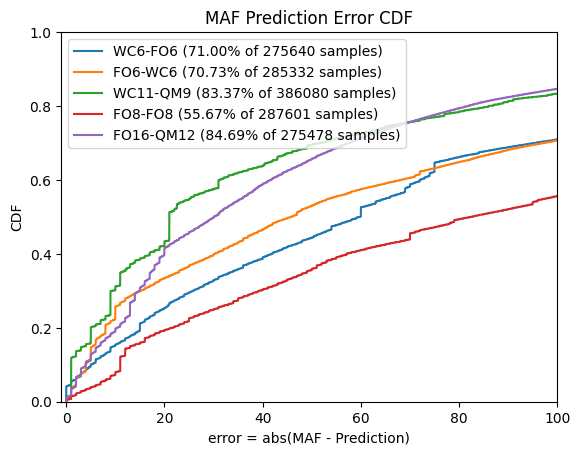

In [82]:


fig, ax = plt.subplots()
xlim = 100
for composition, (maf, prediction) in data.items():
    error = np.abs(maf - prediction)
    mask = error <= xlim
    frac = "{:.2f}".format(100 * np.sum(mask) / len(error))
    ax.ecdf(error, label=f"{composition} ({frac}% of {len(error)} samples)")
    ax.set_xlim(-1, xlim)
    ax.set_xlabel('error = abs(MAF - Prediction)')
    ax.set_ylabel('CDF')
    ax.set_title('MAF Prediction Error CDF')
    ax.legend(loc='upper left')

### Fanout-WChain Prediction

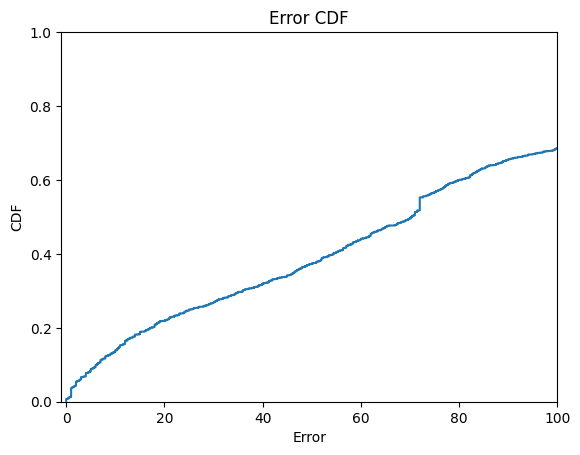

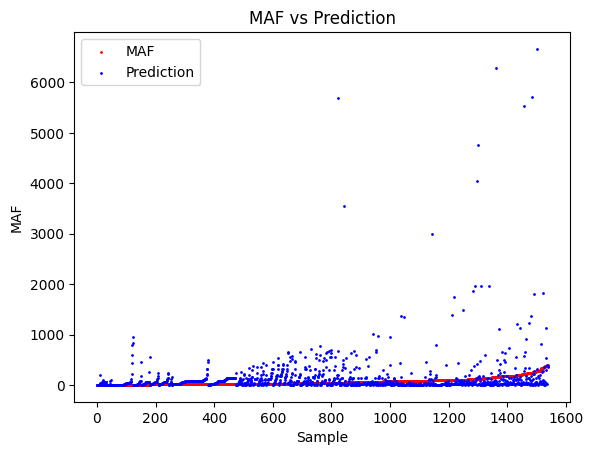

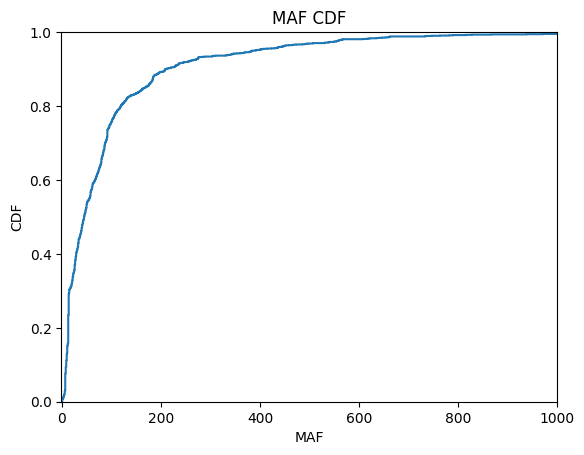

In [13]:

source = 'public1000-3/aggregated/fanout-wchain_prediction.csv'

maf, prediction = load_data(source, 'FO6-WC6', limit=4000)

fig, ax = plt.subplots()
error_plot(ax, maf, prediction, xlim=100, drop=None)

fig, ax = plt.subplots()
scatter_plot(ax, maf, prediction)

fig, ax = plt.subplots()
maf_plot(ax, maf, xlim=1000, drop=None)

### WChain-Fanout Prediction

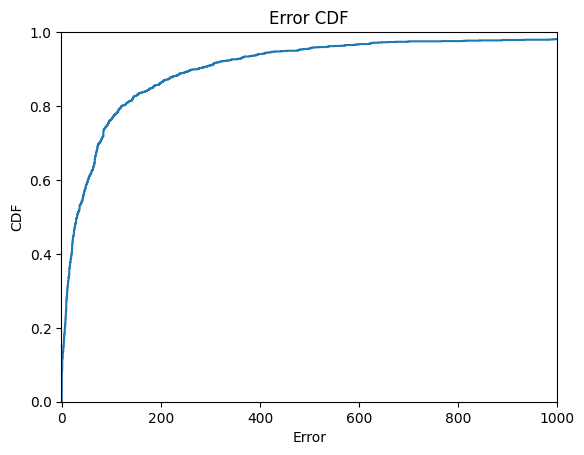

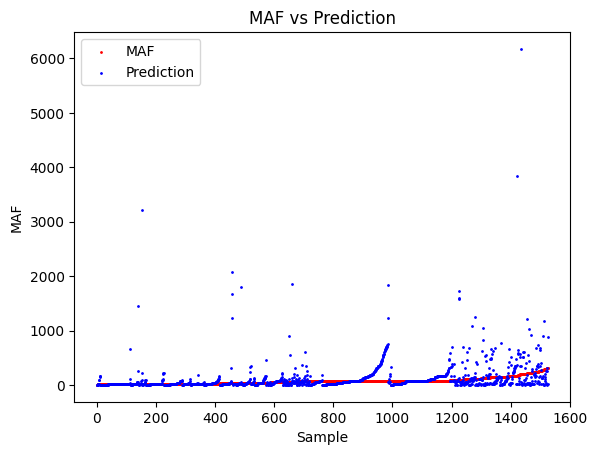

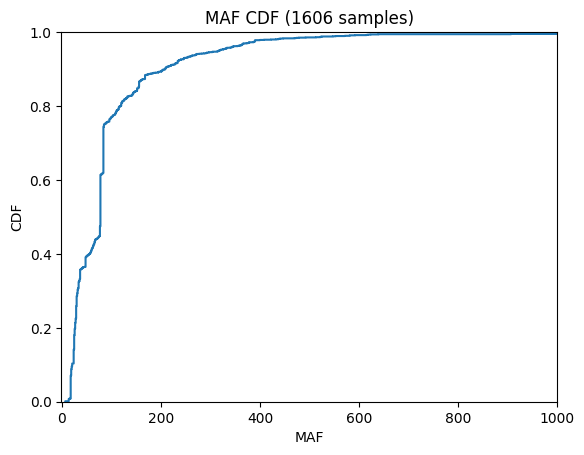

In [39]:

source = 'public1000-3/aggregated/wc6-fo6_prediction.csv'
#source = 'agg600k1vp/wc6-fo6_prediction.csv'

maf, prediction = load_data(source, 'WC6-FO6', limit=None)

fig, ax = plt.subplots()
error_plot(ax, maf, prediction, xlim=1000, drop=None)

fig, ax = plt.subplots()
scatter_plot(ax, maf, prediction)

fig, ax = plt.subplots()
maf_plot(ax, maf, xlim=1000, drop=None)

### WChain-QMIN Prediction

Text(0, 0.5, 'Error')

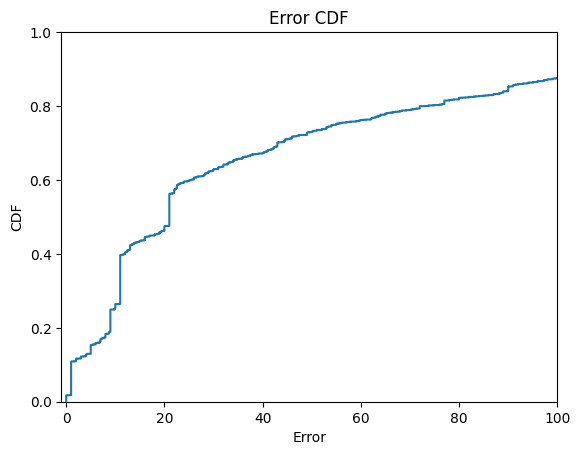

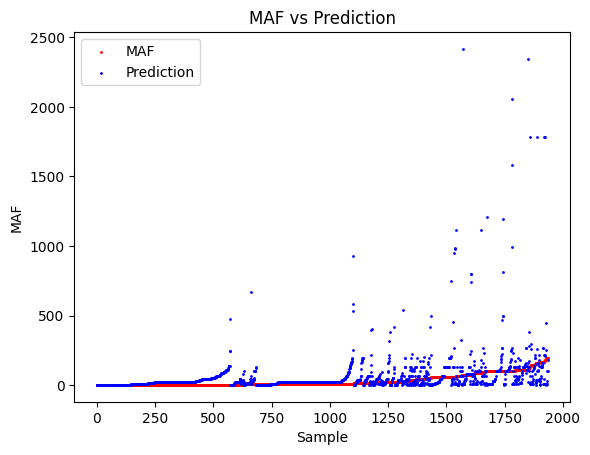

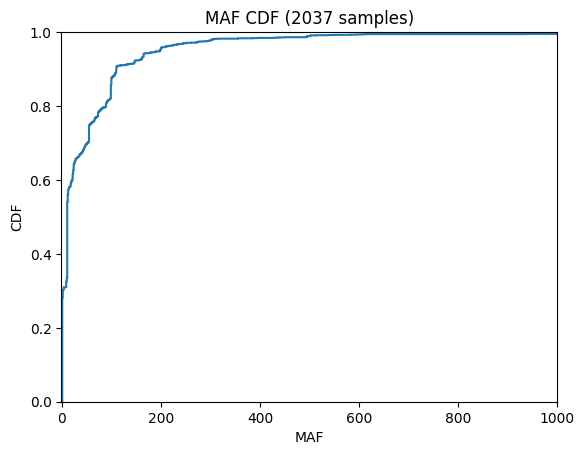

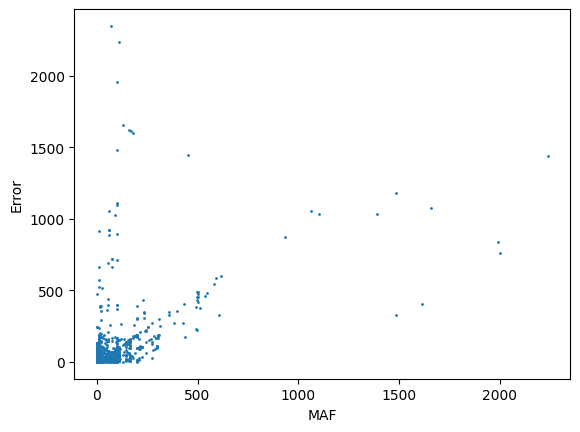

In [11]:

source = 'public1000-3/aggregated/wc11-qm9_prediction.csv'
maf_field = 'maf_amp_WC11-QM9'
pred_field = 'pred_WC11-QM9'

maf, prediction = load_data(source, 'WC11-QM9', limit=4000)

fig, ax = plt.subplots()
error_plot(ax, maf, prediction, xlim=100, drop=None)

fig, ax = plt.subplots()
scatter_plot(ax, maf, prediction)

fig, ax = plt.subplots()
maf_plot(ax, maf, xlim=1000, drop=None)

# Scatter Plot MAF vs. Error
fig, ax = plt.subplots()
ax.scatter(maf, np.abs(maf - prediction), s=1)
ax.set_xlabel('MAF')
ax.set_ylabel('Error')


### CAMP Comparison

#### CDF of all CAMPs

In [75]:
#d = "agg600k1vp"
d = "public1000-3/aggregated"
source = f'{d}/maf.csv'

# The following method of loading only loads samples where all fields are present, i.e. all measurements were successful
prefix = 'maf_amp'
fields = ['WC6-FO6', 'FO6-WC6', 'WC11-QM9', 'FO8-FO8', 'FO16-QM12']

fields = ['maf_amp_WC6-FO6', 'maf_amp_FO6-WC6', 'maf_amp_WC11-QM9', 'maf_amp_FO8-FO8', 'maf_amp_FO16-QM12']
raw = load_fields(source, fields, limit=None, load_successful='any')

data = {
  "WC6-FO6": np.array(raw['maf_amp_WC6-FO6'], dtype=float),
  "FO6-WC6": np.array(raw['maf_amp_FO6-WC6'], dtype=float),
  "WC11-QM9": np.array(raw['maf_amp_WC11-QM9'], dtype=float),
  "FO8-FO8": np.array(raw['maf_amp_FO8-FO8'], dtype=float),
  "FO16-QM12": np.array(raw['maf_amp_FO16-QM12'], dtype=float),
}



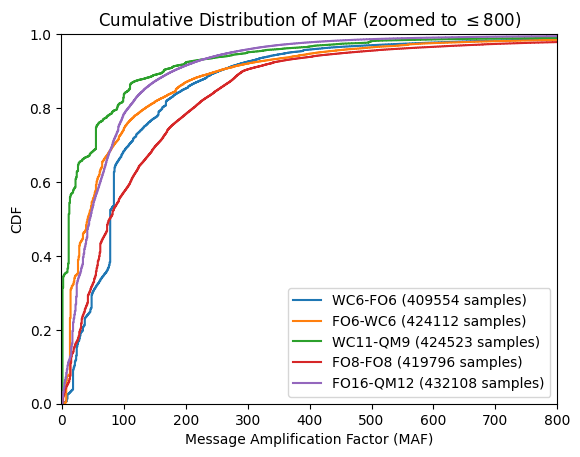

In [76]:

fig, ax = plt.subplots()
xlim = 800

for composition, maf in data.items():
    #mask = maf <= xlim
    #frac = "{:.2f}".format(100 * np.sum(mask) / len(maf))
    #ax.ecdf(maf[mask], label=f"{composition} ({frac}% of {len(maf)} samples)")
    ax.ecdf(maf, label=f"{composition} ({len(maf)} samples)")

ax.set_xlabel('Message Amplification Factor (MAF)')
ax.set_ylabel('CDF')
# Limit x axis
ax.set_xlim(-1,xlim)
ax.set_title(r"Cumulative Distribution of MAF (zoomed to $\leq$" + str(xlim) + ")")
ax.legend(loc='lower right')


#### Scatter of CAMPs: MAF vs. RTT

In [83]:

d = "agg600k1vp"
#d = "public1000-3/aggregated"

source = f'{d}/maf.csv'

def cast(data:dict, dtype):
    for key in data:
        data[key] = np.array(data[key], dtype=dtype)
    #return data
    return tuple(data.values())

#fields = ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6', 'maf_entry_delta_WC6-FO6']
#fields = ['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6', 'maf_entry_delta_FO6-WC6']
#fields = ['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9', 'maf_entry_delta_WC11-QM9']
#fields = ['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8', 'maf_entry_delta_FO8-FO8']
#fields = ['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12', 'maf_entry_delta_FO16-QM12']
data = {
    'WC6-FO6': cast(load_fields(source, ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6'], limit=None, load_successful='all'), float),
    'FO6-WC6': cast(load_fields(source, ['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6'], limit=None, load_successful='all'), float),
    'WC11-QM9': cast(load_fields(source, ['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9'], limit=None, load_successful='all'), float),
    'FO8-FO8': cast(load_fields(source, ['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8'], limit=None, load_successful='all'), float),
    'FO16-QM12': cast(load_fields(source, ['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12'], limit=None, load_successful='all'), float),
}
#fields = ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6']
#data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)

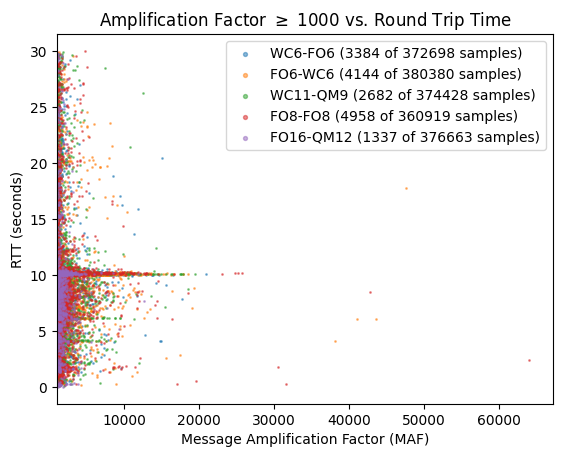

In [53]:

d = "agg600k1vp"
#d = "public1000-3/aggregated"

source = f'{d}/maf.csv'


fig, ax = plt.subplots()

for composition, (maf, rtt) in data.items():
    #mask = (maf >= 1000) & (maf <= 8000)
    mask = maf >= 1000
    frac = "{:.2f}".format(100 * np.sum(mask) / len(maf))
    frac = np.sum(mask)
    ax.scatter(maf[mask], rtt[mask], s=1, label=f'{composition} ({frac} of {len(maf)} samples)', alpha=0.5)

ax.set_xlabel('Message Amplification Factor (MAF)')
ax.set_ylabel('RTT (seconds)')
ax.set_xlim(left=1000)
ax.set_title(r'Amplification Factor $\geq$ 1000 vs. Round Trip Time')
ax.legend(loc='upper right', scatterpoints=1)
for handle in ax.get_legend().legend_handles:
    handle.set_sizes([8])


#### CDF QPS = MAF / RTT

In [72]:

d = "agg600k1vp"
#d = "public1000-3/aggregated"

source = f'{d}/maf.csv'

def cast(data:dict, dtype):
    for key in data:
        data[key] = np.array(data[key], dtype=dtype)
    return data


def get_qps(fields):
    data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)
    #mask = data[fields[0]] > 1000
    #return data[fields[0]][mask] / data[fields[1]][mask]
    return data[fields[0]] / data[fields[1]]

data = {
    'WC6-FO6': get_qps(['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6']),
    'FO6-WC6': get_qps(['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6']),
    'WC11-QM9': get_qps(['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9']),
    'FO8-FO8': get_qps(['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8']),
    'FO16-QM12': get_qps(['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12']),
}

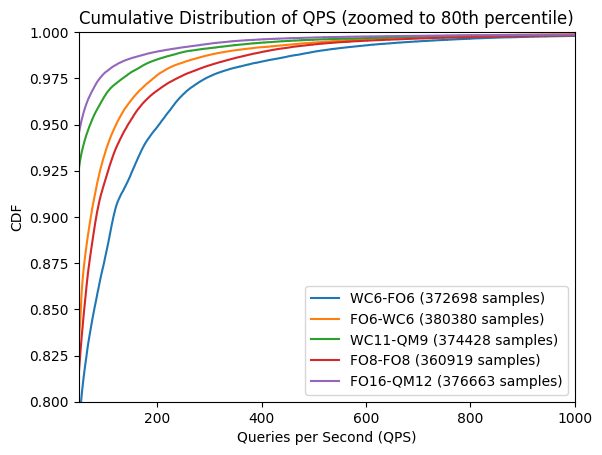

In [74]:

fig, ax = plt.subplots()

percentile = 0.8
for composition, qps in data.items():
    #mask = qps >= 0
    #frac = "{:.2f}".format(100 * np.sum(mask) / len(qps))
    #ax.ecdf(qps[mask], label=f'{composition} ({frac} of {len(qps)} samples)')
    ax.ecdf(qps, label=f'{composition} ({len(qps)} samples)')

ax.set_xlabel('Queries per Second (QPS)')
ax.set_ylabel('CDF')
ax.set_title(f'Cumulative Distribution of QPS (zoomed to {int(percentile*100)}th percentile)')
ax.set_xlim(50, 1000)
ax.set_ylim(0.8, 1)
ax.legend(loc='lower right')


#### QPS vs. Number of Instances

In [86]:

d = "agg600k1vp"
#d = "public1000-3/aggregated"

source = f'{d}/maf.csv'

def cast(data:dict, dtype):
    for key in data:
        data[key] = np.array(data[key], dtype=dtype)
    return data


def get_qps(fields):
    data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)
    return  data[fields[0]] / data[fields[1]]

qps = {}
p1 = 95
p2 = 99

fields = ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6']
data = get_qps(fields)
qps95, qps99 = (np.percentile(data, p1), np.percentile(data, p2))
num95, num99 = (np.sum(data >= qps95), np.sum(data >= qps99))
qps['WC6-FO6'] = (qps95, qps99, num95, num99)
#qps['WC6-FO6'] = (np.percentile(data, p1), np.percentile(data, p2))

fields = ['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6']
data = get_qps(fields)
qps95, qps99 = (np.percentile(data, p1), np.percentile(data, p2))
num95, num99 = (np.sum(data >= qps95), np.sum(data >= qps99))
qps['FO6-WC6'] = (qps95, qps99, num95, num99)

fields = ['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9']
data = get_qps(fields)
qps95, qps99 = (np.percentile(data, p1), np.percentile(data, p2))
num95, num99 = (np.sum(data >= qps95), np.sum(data >= qps99))
qps['WC11-QM9'] = (qps95, qps99, num95, num99)
#qps['WC11-QM9'] = (np.percentile(data, p1), np.percentile(data, p2))
#qps['WC11-QM9'] = get_qps(fields, percentile)

fields = ['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8']
data = get_qps(fields)
qps95, qps99 = (np.percentile(data, p1), np.percentile(data, p2))
num95, num99 = (np.sum(data >= qps95), np.sum(data >= qps99))
qps['FO8-FO8'] = (qps95, qps99, num95, num99)
#qps['FO8-FO8'] = (np.percentile(data, p1), np.percentile(data, p2))
#qps['FO8-FO8'] = get_qps(fields, percentile)

fields = ['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12']
data = get_qps(fields)
qps95, qps99 = (np.percentile(data, p1), np.percentile(data, p2))
num95, num99 = (np.sum(data >= qps95), np.sum(data >= qps99))
qps['FO16-QM12'] = (qps95, qps99, num95, num99)
#qps['FO16-QM12'] = (np.percentile(data, p1), np.percentile(data, p2))
#qps['FO16-QM12'] = get_qps(fields, percentile)

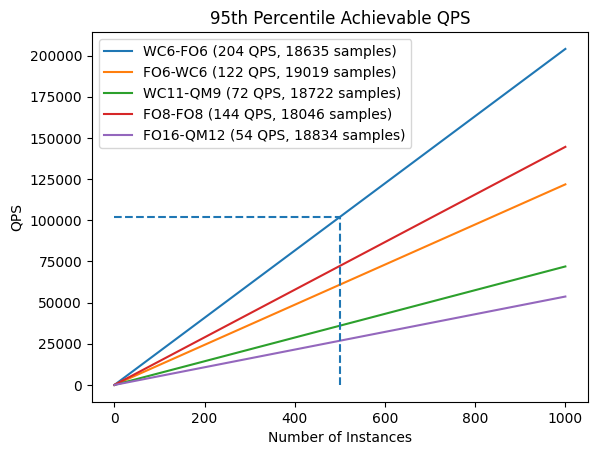

In [97]:


# 95th percentile
fig, ax = plt.subplots()
limit = 1000
x = np.linspace(0, limit+1, limit)
ax.plot(x, qps['WC6-FO6'][0]*x, label=f'WC6-FO6 ({qps["WC6-FO6"][0]:.0f} QPS, {qps["WC6-FO6"][2]} samples)')
ax.plot(x, qps['FO6-WC6'][0]*x, label=f'FO6-WC6 ({qps["FO6-WC6"][0]:.0f} QPS, {qps["FO6-WC6"][2]} samples)')
ax.plot(x, qps['WC11-QM9'][0]*x, label=f'WC11-QM9 ({qps["WC11-QM9"][0]:.0f} QPS, {qps["WC11-QM9"][2]} samples)')
ax.plot(x, qps['FO8-FO8'][0]*x, label=f'FO8-FO8 ({qps["FO8-FO8"][0]:.0f} QPS, {qps["FO8-FO8"][2]} samples)')
ax.plot(x, qps['FO16-QM12'][0]*x, label=f'FO16-QM12 ({qps["FO16-QM12"][0]:.0f} QPS, {qps["FO16-QM12"][2]} samples)')

ind = 500
ax.vlines(x=500, ymin=0, ymax=qps['WC6-FO6'][0]*500, color='C0', linestyle='dashed')
ax.hlines(y=qps['WC6-FO6'][0]*500, xmin=0, xmax=500, color='C0', linestyle='dashed')

ax.set_xlabel('Number of Instances')
ax.set_ylabel('QPS')
ax.set_title(f'{p1}th Percentile Achievable QPS')
ax.legend(loc='upper left')

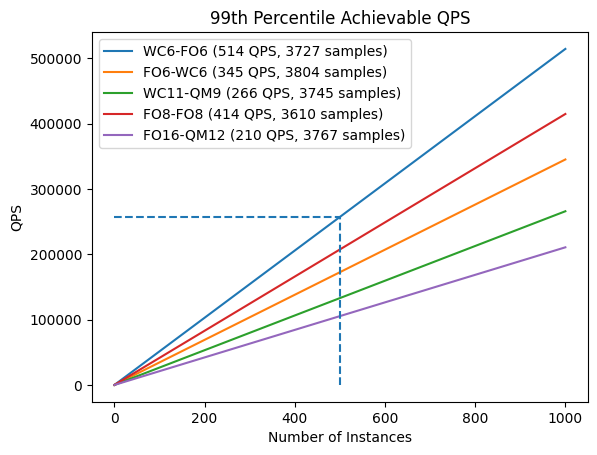

In [96]:


# Max
fig, ax = plt.subplots()
limit = 1000
x = np.linspace(0, limit+1, limit)
ax.plot(x, qps['WC6-FO6'][1]*x, label=f'WC6-FO6 ({qps["WC6-FO6"][1]:.0f} QPS, {qps["WC6-FO6"][3]} samples)')
ax.plot(x, qps['FO6-WC6'][1]*x, label=f'FO6-WC6 ({qps["FO6-WC6"][1]:.0f} QPS, {qps["FO6-WC6"][3]} samples)')
ax.plot(x, qps['WC11-QM9'][1]*x, label=f'WC11-QM9 ({qps["WC11-QM9"][1]:.0f} QPS, {qps["WC11-QM9"][3]} samples)')
ax.plot(x, qps['FO8-FO8'][1]*x, label=f'FO8-FO8 ({qps["FO8-FO8"][1]:.0f} QPS, {qps["FO8-FO8"][3]} samples)')
ax.plot(x, qps['FO16-QM12'][1]*x, label=f'FO16-QM12 ({qps["FO16-QM12"][1]:.0f} QPS, {qps["FO16-QM12"][3]} samples)')

ind = 500
ax.vlines(x=ind, ymin=0, ymax=qps['WC6-FO6'][1]*ind, color='C0', linestyle='dashed')
ax.hlines(y=qps['WC6-FO6'][1]*ind, xmin=0, xmax=ind, color='C0', linestyle='dashed')

ax.set_xlabel('Number of Instances')
ax.set_ylabel('QPS')
ax.set_title(f'{p2}th Percentile Achievable QPS')
ax.legend(loc='upper left')


#### Print Info

In [43]:

d = "agg600k1vp"
#d = "public1000-3/aggregated"

source = f'{d}/maf.csv'

def cast(data:dict, dtype):
    for key in data:
        data[key] = np.array(data[key], dtype=dtype)
    return data

def print_info(d):
    print(f"Total: {len(d)}", end=' ')
    above100 = d > 100
    print(f"MAF: Above 100: {np.sum(above100)}, {np.sum(above100) / len(d) * 100:.2f}%", end=' ')
    above1000 = d > 1000
    print(f"Above 1000: {np.sum(above1000)}, {np.sum(above1000) / len(d) * 100:.2f}%", end=' ')
    above8000 = d > 8000
    print(f"Above 8000: {np.sum(above8000)}, {np.sum(above8000) / len(d) * 100:.2f}%", end=' ')
    print(f"Max: {np.max(d)}")

#fields = ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6', 'maf_entry_delta_WC6-FO6']
#fields = ['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6', 'maf_entry_delta_FO6-WC6']
#fields = ['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9', 'maf_entry_delta_WC11-QM9']
#fields = ['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8', 'maf_entry_delta_FO8-FO8']
#fields = ['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12', 'maf_entry_delta_FO16-QM12']
fields = ['maf_amp_WC6-FO6', 'maf_amp_FO6-WC6', 'maf_amp_WC11-QM9', 'maf_amp_FO8-FO8', 'maf_amp_FO16-QM12']
#fields = ['maf_amp_WC6-FO6']
data = cast(load_fields(source, fields, limit=None, load_successful='any'), float)
print("WC6-FO6")
print_info(data['maf_amp_WC6-FO6'])
print("FO6-WC6")
print_info(data['maf_amp_FO6-WC6'])
print("WC11-QM9")
print_info(data['maf_amp_WC11-QM9'])
print("FO8-FO8")
print_info(data['maf_amp_FO8-FO8'])
print("FO16-QM12")
print_info(data['maf_amp_FO16-QM12'])

# Among NO TIMEOUT samples
print("NO TIMEOUT")

fields = ['maf_amp_WC6-FO6', 'maf_rtt_WC6-FO6']
data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)['maf_amp_WC6-FO6']
print("WC6-FO6")
print_info(data)

fields = ['maf_amp_FO6-WC6', 'maf_rtt_FO6-WC6']
data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)['maf_amp_FO6-WC6']
print("FO6-WC6")
print_info(data)

fields = ['maf_amp_WC11-QM9', 'maf_rtt_WC11-QM9']
data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)['maf_amp_WC11-QM9']
print("WC11-QM9")
print_info(data)

fields = ['maf_amp_FO8-FO8', 'maf_rtt_FO8-FO8']
data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)['maf_amp_FO8-FO8']
print("FO8-FO8")
print_info(data)

fields = ['maf_amp_FO16-QM12', 'maf_rtt_FO16-QM12']
data = cast(load_fields(source, fields, limit=None, load_successful='all'), float)['maf_amp_FO16-QM12']
print("FO16-QM12")
print_info(data)

WC6-FO6
Total: 409554 MAF: Above 100: 129291, 31.57% Above 1000: 3989, 0.97% Above 8000: 68, 0.02% Max: 23121.0
FO6-WC6
Total: 424112 MAF: Above 100: 107809, 25.42% Above 1000: 4515, 1.06% Above 8000: 162, 0.04% Max: 47611.0
WC11-QM9
Total: 424523 MAF: Above 100: 68853, 16.22% Above 1000: 3285, 0.77% Above 8000: 62, 0.01% Max: 19451.0
FO8-FO8
Total: 419796 MAF: Above 100: 179025, 42.65% Above 1000: 6213, 1.48% Above 8000: 117, 0.03% Max: 64103.0
FO16-QM12
Total: 432108 MAF: Above 100: 92996, 21.52% Above 1000: 1595, 0.37% Above 8000: 7, 0.00% Max: 45614.0
NO TIMEOUT
WC6-FO6
Total: 372698 MAF: Above 100: 115684, 31.04% Above 1000: 3380, 0.91% Above 8000: 67, 0.02% Max: 20909.0
FO6-WC6
Total: 380380 MAF: Above 100: 92026, 24.19% Above 1000: 4138, 1.09% Above 8000: 160, 0.04% Max: 47611.0
WC11-QM9
Total: 374428 MAF: Above 100: 53542, 14.30% Above 1000: 2678, 0.72% Above 8000: 60, 0.02% Max: 19451.0
FO8-FO8
Total: 360919 MAF: Above 100: 154043, 42.68% Above 1000: 4952, 1.37% Above 8000: 10